In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ray
import seaborn as sns
import math
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_style("ticks",{'axes.grid' : True})
import scienceplots
plt.style.use('science')
color_arr = ['#3F90DA', '#FFA90E', '#BD1F01', '#94A4A2', '#832DB6', '#A96B59', '#E76300', '#B9AC70', '#92DADD']
try:
    import cPickle as pickle
except ImportError:
    import pickle

In [ ]:
def Metropolis_Function_PBC(S, E, J, B, beta, L): 
    # Place flip at some location in the domain 
    ii = (np.random.randint(L) ) % L ## 
    jj = (np.random.randint(L) ) % L

    ### First flip external field contribution
    dE = 2 * B * S[ii, jj] 
    ## Then Flip Neighbors
    for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                dE += 2 * J * S[ii, jj] * S[(ii + di) % L, (jj + dj) % L]
    # Metropolis Transition
    if(dE <= 0):
        flip = True
    else:
        p = np.exp(-beta*dE)
        if np.random.rand() < p:
            flip = True
        else:
            flip = False

    if(flip == True):
        E += dE
        S[ii, jj] *= -1 # Flip 
    return S, E

In [ ]:
@ray.remote
def run_simulation(L, beta, total_iters, equilibration_steps, J, B):
    S = np.random.choice([-1, 1], size=(L, L))
    E = -J * np.sum(S * (np.roll(S, 1, axis=0) + np.roll(S, 1, axis=1))) + -B * np.sum(S)
    m_arr = []
    E_arr = []

    print(f"Starting simulation: L={L}, beta={beta}, B={B}")

    # Equilibration
    for i in range(0, equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L)

    # Measurement
    for i in range(0, total_iters - equilibration_steps):
        S, E = Metropolis_Function_PBC(S, E, J, B, beta, L)
        m_arr.append(np.sum(S))
        E_arr.append(E)

    m_arr = np.array(m_arr)
    E_arr = np.array(E_arr)

    m_mean = np.mean(m_arr) / L**2
    E_mean = np.mean(E_arr) / L**2

    print(f"Finished simulation: L={L}, beta={beta}, B={B}, m_mean={m_mean}, E_mean={E_mean}")
    return L, B, m_mean, E_mean

# Ray v3

In [5]:
ray.shutdown()

In [ ]:
# Initial Conditions
J = 1
beta = 10  
num_B_values = 100  
B_min = -0.1
B_max = 0.1
B_arr = np.linspace(B_min, B_max, num_B_values)
iters = 8000001
L_arr = [100, 250, 500] 
iters_arr = [8000001, 8000001, 8000001, 8000001, 8000001, 8000001] 

equilibration_fraction = 0.9
equilibration_steps = int(iters * equilibration_fraction)

ray.init()
futures = []
for ll, L in enumerate(L_arr):
    print(f'Submitting tasks for L = {L}')
    total_iters = iters_arr[ll]
    equilibration_steps = int(total_iters * equilibration_fraction)
    for B_val in B_arr:
        future = run_simulation.remote(L, beta, total_iters, equilibration_steps, J, B_val)
        futures.append((L, B_val, future))

m_mean_data_Lvar = {L: [] for L in L_arr}
E_mean_data_Lvar = {L: [] for L in L_arr}

print("Retrieving results...")
for L, B_val, future in futures:
    L_result, B_result, m_mean, E_mean = ray.get(future)
    m_mean_data_Lvar[L].append(m_mean)
    E_mean_data_Lvar[L].append(E_mean)
    print(f"L={L}, log10(B)={(B_val):.2f}, |m|={abs(m_mean):.3f}")

ray.shutdown()

####################################### PLOTTING
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    b_vals = [item[0] for item in sorted(zip(B_arr, m_mean_data_Lvar[L]))]
    abs_m_vals = [abs(item[1]) for item in sorted(zip(B_arr, m_mean_data_Lvar[L]))]
    plt.plot((b_vals), abs_m_vals, label=f'L = {L}', color=colors[i])

plt.xlabel(r'$\textbf{External Field} \; \mathbf{B}$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Magnetization}} \, \left<m\right>}$', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
for i, L in enumerate(sorted(L_arr)):
    b_vals = [item[0] for item in sorted(zip(B_arr, E_mean_data_Lvar[L]))]
    e_vals = [item[1] for item in sorted(zip(B_arr, E_mean_data_Lvar[L]))]
    plt.plot(b_vals, e_vals, label=f'L = {L}', color=colors[i])

plt.xlabel(r'$\textbf{External Field} \; \mathbf{B}$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Energy Density}} \; \mathbf{E/L^2}}$', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

2025-05-06 07:48:54,582	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 192.168.110.194:6379...
2025-05-06 07:48:54,596	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Submitting tasks for L = 100
Submitting tasks for L = 250
Submitting tasks for L = 500
Retrieving results...
(run_simulation pid=21428) Starting simulation: L=100, beta=10, B=-0.1
(run_simulation pid=21428)   Equilibration step: 0, E=15.399999999999999
(run_simulation pid=18248, ip=192.168.110.135) Starting simulation: L=100, beta=10, B=-0.009090909090909094 [repeated 47x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(run_simulation pid=4804)   Equilibration step: 149000, E=-19124.95555555412 [repeated 8345x across cluster]
(run_simulation pid=27780, ip=192.168.110.184) 
(run_simulation pid=28256) 
(run_simulation pid=11852, ip=192.168.110.184) Starting simulation: L=100, beta=10, B=0.027272727272727254 [repeated 16x across cluster]
(run_simulation pid=27888)   Equilibration step: 527000, E=-20656.56565656

RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{\\\\mathrm{External Field B}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpbxgskqjw eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(c:/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(c:/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(c:/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(c:/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(c:/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(c:/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(c:/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(c:/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(c:/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(c:/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amssymb.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(c:/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(c:/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(c:/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(c:/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing } inserted.
<inserted text> 
                }
l.30 ...amily $\mathbf{\mathrm{External Field B}$}
                                                  %
No pages of output.
Transcript written on tmpbxgskqjw/eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2e
af8c85e2c25f5a7ea6a.log.




Error in callback <function _draw_all_if_interactive at 0x0000012CF0AD1300> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{\\\\mathrm{External Field B}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpa8gx635c eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(c:/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(c:/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(c:/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(c:/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(c:/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(c:/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(c:/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(c:/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(c:/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(c:/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amssymb.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(c:/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(c:/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(c:/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(c:/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing } inserted.
<inserted text> 
                }
l.30 ...amily $\mathbf{\mathrm{External Field B}$}
                                                  %
No pages of output.
Transcript written on tmpa8gx635c/eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2e
af8c85e2c25f5a7ea6a.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\mathbf{\\\\mathrm{External Field B}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp5cetl1xw eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(c:/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(c:/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(c:/texlive/2025/texmf-dist/tex/latex/type1cm/type1cm.sty)
(c:/texlive/2025/texmf-dist/tex/latex/cm-super/type1ec.sty
(c:/texlive/2025/texmf-dist/tex/latex/base/t1cmr.fd))
(c:/texlive/2025/texmf-dist/tex/latex/base/inputenc.sty)
(c:/texlive/2025/texmf-dist/tex/latex/geometry/geometry.sty
(c:/texlive/2025/texmf-dist/tex/latex/graphics/keyval.sty)
(c:/texlive/2025/texmf-dist/tex/generic/iftex/ifvtex.sty
(c:/texlive/2025/texmf-dist/tex/generic/iftex/iftex.sty)))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amstext.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsgen.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(c:/texlive/2025/texmf-dist/tex/latex/amsmath/amsopn.sty))
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amssymb.sty
(c:/texlive/2025/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(c:/texlive/2025/texmf-dist/tex/latex/underscore/underscore.sty)
(c:/texlive/2025/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(c:/texlive/2025/texmf-dist/tex/latex/base/textcomp.sty)
(c:/texlive/2025/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2eaf8c85e2c25f5a7ea6a.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing } inserted.
<inserted text> 
                }
l.30 ...amily $\mathbf{\mathrm{External Field B}$}
                                                  %
No pages of output.
Transcript written on tmp5cetl1xw/eac9532c4b445ff7ad3d774549dad9562d2371aa3bb2e
af8c85e2c25f5a7ea6a.log.




<Figure size 600x400 with 1 Axes>

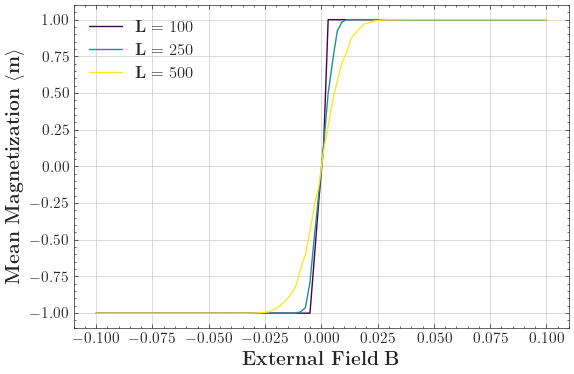

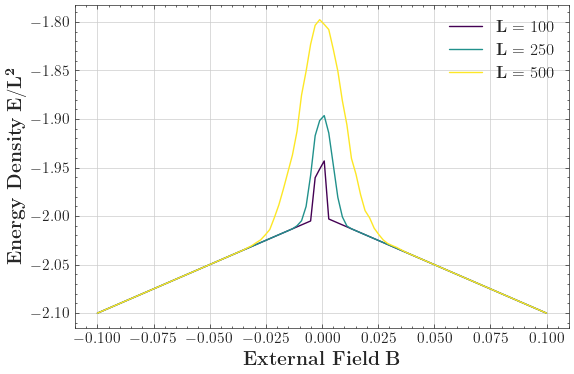

In [ ]:
# Plotting
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, len(L_arr)))

for i, L in enumerate(sorted(L_arr)):
    if(L != 10 and L != 1000):
        b_vals = [item[0] for item in sorted(zip(B_arr, m_mean_data_Lvar[L]))]
        abs_m_vals = [(item[1]) for item in sorted(zip(B_arr, m_mean_data_Lvar[L]))]
        plt.plot((b_vals), abs_m_vals, label=r'$\mathbf{L =}$' + f' {L}', color=colors[i])

plt.xlabel(r'$\textbf{External Field} \; \mathbf{B}$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Mean Magnetization}} \, \left<m\right>}$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('External-Field-m.pdf')
plt.show()

plt.figure(figsize=(6, 4))
for i, L in enumerate(sorted(L_arr)):
    b_vals = [item[0] for item in sorted(zip(B_arr, E_mean_data_Lvar[L]))]
    e_vals = [item[1] for item in sorted(zip(B_arr, E_mean_data_Lvar[L]))]
    plt.plot(b_vals, e_vals, label=r'$\mathbf{L =}$' + f' {L}', color=colors[i])

plt.xlabel(r'$\textbf{External Field} \; \mathbf{B}$', fontsize=14)
plt.ylabel(r'$\mathbf{\mathrm{\textbf{Energy Density}} \; \mathbf{E/L^2}}$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('External-Field-E.pdf')
plt.show()